In [1]:
import mygene

In [2]:
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

pandas2ri.activate()
DESeq2 = importr("DESeq2")

from rpy2.robjects import default_converter
from rpy2.robjects.conversion import rpy2py
base = importr("base")

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 


In [3]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

In [4]:
def get_count_matrix(mock_24A, mock_24B, S2_24A, S2_24B):
    # create an empty dataframe with the union of all values of the 'mirna' column in these 4 dataframes as the index
    index_union = set(mock_24A['mirna']).union(set(mock_24B['mirna'])).union(set(S2_24A['mirna'])).union(set(S2_24B['mirna']))
    new_df = pd.DataFrame(index=list(index_union))

    # iterate over the 4 dataframes and for each dataframe, add a column with the values of 'Unnormalized read counts' named the same as the dataframe
    new_df['mock_24A'] = 0
    new_df['mock_24B'] = 0
    new_df['S2_24A'] = 0
    new_df['S2_24B'] = 0


    # use a for loop to iterate over each row of each dataframe and add the value of 'Unnormalized read counts' to the corresponding row in the new dataframe

    for index, row in mock_24A.iterrows():
        if row['mirna'] in new_df.index:
            new_df.at[row['mirna'], 'mock_24A'] = row['Unnormalized read counts']
    for index, row in mock_24B.iterrows():
        if row['mirna'] in new_df.index:
            new_df.at[row['mirna'], 'mock_24B'] = row['Unnormalized read counts']
    for index, row in S2_24A.iterrows():
        if row['mirna'] in new_df.index:
            new_df.at[row['mirna'], 'S2_24A'] = row['Unnormalized read counts']
    for index, row in S2_24B.iterrows():
        if row['mirna'] in new_df.index:
            new_df.at[row['mirna'], 'S2_24B'] = row['Unnormalized read counts']

    # fill missing values with zero
    new_df.fillna(0, inplace=True)
    return new_df

In [5]:
# 4 hrs
mock_4A = pd.read_csv('mir_SRR11550017_GSM4477934_Calu3_smallRNA-mock-4h-A.csv')
mock_4B = pd.read_csv('mir_SRR11550018_GSM4477935_Calu3_smallRNA-mock-4h-B.csv')
S2_4A = pd.read_csv('mir_SRR11550029_GSM4477946_Calu3_smallRNA-S2-4h-A.csv')
S2_4B = pd.read_csv('mir_SRR11550030_GSM4477947_Calu3_smallRNA-S2-4h-B.csv')

counts4 = get_count_matrix(mock_4A,mock_4B,S2_4A, S2_4B)

In [33]:
counts4.index

Index([             'hsa-miR-200c-5p|+1|-1',
               'hsa-miR-1307-3p|+1|-2(+2C)',
             '16|+|22297215|22297236|-3|0]',
                        'hsa-miR-577|+1|-1',
                      'hsa-miR-29b-3p|0|-3',
                 'hsa-miR-27b-3p|+3|0(+1U)',
               'hsa-miR-200c-3p|-1|-4(+1G)',
                'hsa-miR-452-3p|-6|-6(+1G)',
                       'hsa-miR-186-5p|0|0',
                'hsa-miR-29b-3p|+1|-4(+1C)',
       ...
                       'offsets|-1|+1(+1U)',
                       'offsets|-1|-7(+1C)',
                  'hsa-miR-328-3p|0|0(+2U)',
               'hsa-miR-6832-5p|+2|+5(+1C)',
       '22|-|29333176|29333193|-8|-4(+1U)]',
                  'hsa-miR-25-3p|0|-3(+3G)',
                     'hsa-miR-502-5p|-1|+4',
               'hsa-miR-6784-5p|+3|+2(+1U)',
                 'hsa-miR-574-3p|0|-3(+2U)',
                 'hsa-miR-423-3p|+2|0(+2U)'],
      dtype='object', length=18386)

In [7]:
def deseq(meta: pd.DataFrame, counts: pd.DataFrame, formula: str, ref: str, exp: str):
    # Calculate normalization factors
    dds = DESeq2.DESeqDataSetFromMatrix(
        countData=counts, colData=meta, design=ro.Formula(formula))
    
    dds = DESeq2.DESeq(dds) #parallel=True
    #estimateSizeFactors(dds, type = 'iterate')
    
    print(f"experiment_{exp}_vs_{ref}")
    resR = DESeq2.results(dds, name=f"experiment_{ref}_vs_{exp}")
    res = r_to_df(resR)
    res = res.sort_values("padj")
    res = res.loc[res["padj"] < 0.05]
    res = res.loc[res["log2FoldChange"].abs() > 0.5]

    return res


def r_to_df(r_df):
    with localconverter(default_converter + pandas2ri.converter):
        return rpy2py(base.as_data_frame(r_df))

In [8]:
design = pd.DataFrame({
    "experiment": [sample_name.split("_")[0] for sample_name in counts4.columns],
    #"hpi": [sample_name.split("-")[2] for sample_name in counts.columns],
}, index=counts4.columns)

In [9]:
design

,experiment
mock_24A,mock
mock_24B,mock
S2_24A,S2
S2_24B,S2


In [10]:
res_4 = deseq(meta=design, counts=counts4, formula="~experiment", ref="mock", exp="S2")
res_4 

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



experiment_S2_vs_mock


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
hsa-miR-374a-5p|0|-1,267.783632,3.593546,0.456806,7.866673,3.641980e-15,3.350622e-12
hsa-miR-374a-5p|0|-2(+1C),165.066056,3.550321,0.549282,6.463562,1.022668e-10,4.704272e-08
hsa-miR-135b-5p|0|-2,206.148833,3.310910,0.562699,5.883984,4.005068e-09,1.228221e-06
hsa-miR-374a-5p|0|0,77.817410,3.382534,0.600524,5.632638,1.774735e-08,4.081890e-06
hsa-miR-21-5p|0|+1(+1G),351.416064,2.293451,0.413145,5.551200,2.837153e-08,5.220362e-06
...,...,...,...,...,...,...
hsa-let-7a-3p|0|0(+1U),214.862861,1.345309,0.462733,2.907311,3.645501e-03,4.299821e-02
hsa-miR-29a-3p|-1|-3,90.506208,1.813095,0.625445,2.898887,3.744897e-03,4.361146e-02
hsa-miR-30c-5p|0|0,1357.619661,1.075470,0.372604,2.886359,3.897269e-03,4.481859e-02
hsa-miR-200b-3p|0|-2(+1U),40.172043,1.873051,0.654615,2.861301,4.219066e-03,4.792026e-02


In [32]:
res_4.index

Index(['hsa-miR-374a-5p|0|-1', 'hsa-miR-374a-5p|0|-2(+1C)',
       'hsa-miR-135b-5p|0|-2', 'hsa-miR-374a-5p|0|0',
       'hsa-miR-21-5p|0|+1(+1G)', 'hsa-miR-21-5p|0|+1(+1C)',
       'hsa-miR-21-5p|0|-1(+1U)', 'hsa-miR-135b-5p|0|-3(+1C)',
       'hsa-miR-21-5p|0|+2', 'hsa-miR-135b-5p|0|-1', 'hsa-miR-429|0|-2',
       'hsa-miR-21-5p|0|+1', 'hsa-miR-21-5p|0|-3(+2G)', 'hsa-miR-429|0|-1',
       'hsa-miR-21-5p|0|-1(+1G)', 'hsa-miR-21-5p|0|0(+1U)',
       'hsa-miR-21-5p|0|0(+1G)', 'hsa-miR-16-5p|0|+1', 'hsa-miR-429|0|0',
       'hsa-miR-21-5p|0|-1(+1C)', 'hsa-miR-21-5p|0|-2', 'hsa-miR-194-5p|0|-1',
       'hsa-miR-29a-3p|0|-4', 'hsa-miR-21-5p|0|-1', 'hsa-miR-21-5p|0|-2(+1C)',
       'hsa-miR-374a-3p|0|0', 'hsa-miR-16-5p|0|-1', 'hsa-miR-29c-3p|0|-2',
       'hsa-miR-16-5p|0|-1(+1C)', 'hsa-miR-21-5p|0|-3(+1C)',
       'hsa-miR-21-5p|0|-3', 'hsa-miR-21-5p|0|-1(+2C)', 'hsa-miR-27b-3p|0|0',
       'hsa-miR-29c-3p|0|-3', 'hsa-miR-29a-3p|0|-2(+1G)',
       'hsa-miR-200b-3p|0|+1', 'hsa-miR-362-3p|0|

In [11]:
#there is no mock for 12hpi, so i use mock 4 hpi

mock_12A = pd.read_csv('mir_SRR11550017_GSM4477934_Calu3_smallRNA-mock-4h-A.csv')
mock_12B = pd.read_csv('mir_SRR11550018_GSM4477935_Calu3_smallRNA-mock-4h-B.csv')

S2_12A = pd.read_csv('mir_SRR11550025_GSM4477942_Calu3_smallRNA-S2-12h-A.csv')
S2_12B = pd.read_csv('mir_SRR11550026_GSM4477943_Calu3_smallRNA-S2-12h-B.csv')

counts12 = get_count_matrix(mock_12A,mock_12B,S2_12A, S2_12B)
res_12 = deseq(meta=design, counts=counts12, formula="~experiment", ref="mock", exp="S2")
res_12

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



experiment_S2_vs_mock


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
hsa-miR-155-3p|0|-1,130.448108,-3.596386,0.569850,-6.311111,2.770396e-10,2.446259e-07
hsa-miR-374a-5p|0|-1,235.831515,2.888702,0.515614,5.602445,2.113490e-08,9.331060e-06
hsa-miR-374a-5p|0|-2(+1C),145.115722,2.864582,0.575180,4.980324,6.347807e-07,1.868371e-04
hsa-miR-135b-5p|0|-2,182.757548,2.615447,0.577637,4.527839,5.959005e-06,1.315450e-03
hsa-miR-21-5p|0|+1(+1C),322.299280,1.817629,0.415642,4.373065,1.225141e-05,2.163600e-03
hsa-miR-29a-3p|0|-4,170.029424,2.711217,0.635078,4.269106,1.962580e-05,2.888263e-03
hsa-miR-135b-5p|0|-3(+1C),134.989203,2.641035,0.625054,4.225291,2.386320e-05,3.010173e-03
hsa-miR-21-5p|0|+2,293.088479,1.757597,0.423193,4.153178,3.278894e-05,3.619079e-03
hsa-miR-135b-5p|0|-1,270.784431,2.443935,0.603427,4.050092,5.119758e-05,4.520746e-03
hsa-miR-374a-5p|0|0,70.182087,2.505444,0.616306,4.065263,4.797826e-05,4.520746e-03


In [12]:
res_12.index

Index(['hsa-miR-155-3p|0|-1', 'hsa-miR-374a-5p|0|-1',
       'hsa-miR-374a-5p|0|-2(+1C)', 'hsa-miR-135b-5p|0|-2',
       'hsa-miR-21-5p|0|+1(+1C)', 'hsa-miR-29a-3p|0|-4',
       'hsa-miR-135b-5p|0|-3(+1C)', 'hsa-miR-21-5p|0|+2',
       'hsa-miR-135b-5p|0|-1', 'hsa-miR-374a-5p|0|0',
       'hsa-miR-21-5p|0|+1(+1G)', 'hsa-miR-21-5p|0|-1(+1G)',
       'hsa-miR-424-5p|+1|-2', 'hsa-miR-429|0|-2', 'hsa-miR-16-5p|0|+1',
       'hsa-miR-424-5p|0|-2', 'hsa-miR-21-5p|0|-3(+2G)', 'hsa-miR-29a-3p|0|-2',
       'hsa-miR-21-5p|0|-1(+1U)', 'hsa-miR-29a-3p|0|-3', 'hsa-miR-27b-3p|0|0',
       'hsa-miR-29c-3p|0|-1', 'hsa-miR-29a-3p|0|-2(+1G)',
       'hsa-miR-29c-3p|0|-3(+1C)', 'hsa-miR-429|0|0', 'hsa-miR-29c-3p|0|-3',
       'hsa-miR-21-5p|0|-1(+1C)', 'hsa-miR-200b-3p|0|+1(+1C)',
       'hsa-miR-141-3p|0|-1', 'hsa-miR-27a-3p|0|0', 'hsa-miR-330-5p|0|+1',
       'hsa-miR-21-5p|0|-2', 'hsa-miR-21-5p|0|-2(+1C)',
       'hsa-miR-21-5p|0|0(+1U)', 'hsa-miR-16-5p|0|-1', 'hsa-miR-194-5p|0|-2',
       'hsa-miR-2

In [13]:
# 24 hpi

mock_24A = pd.read_csv('mir_SRR11550015_GSM4477932_Calu3_smallRNA-mock-24h-A.csv')
mock_24B = pd.read_csv('mir_SRR11550016_GSM4477933_Calu3_smallRNA-mock-24h-B.csv')
S2_24A = pd.read_csv('mir_SRR11550027_GSM4477944_Calu3_smallRNA-S2-24h-A.csv')
S2_24B = pd.read_csv('mir_SRR11550028_GSM4477945_Calu3_smallRNA-S2-24h-B.csv')

counts24 = get_count_matrix(mock_24A,mock_24B,S2_24A, S2_24B)
res_24 = deseq(meta=design, counts=counts24, formula="~experiment", ref="mock", exp="S2")
res_24

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



experiment_S2_vs_mock


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
hsa-miR-23b-3p|0|0,817.972103,2.289267,0.319389,7.167636,7.630364e-13,2.653841e-09
hsa-miR-374a-5p|0|-1,110.324059,2.516898,0.412551,6.100819,1.055264e-09,1.709594e-06
hsa-miR-155-3p|0|-1,70.321344,-3.417840,0.565202,-6.047114,1.474636e-09,1.709594e-06
hsa-miR-429|0|-2,595.265307,1.734880,0.292838,5.924368,3.135012e-09,2.725893e-06
hsa-miR-21-5p|0|-3,328.087910,1.662213,0.301626,5.510849,3.571068e-08,2.484035e-05
hsa-let-7a-3p|0|+1,82.756759,2.361732,0.438444,5.386629,7.179161e-08,4.161520e-05
hsa-miR-23b-3p|0|-2,4333.726051,1.154441,0.220701,5.230792,1.687856e-07,8.386235e-05
hsa-miR-21-5p|0|-2,1316.375935,1.277279,0.245695,5.198637,2.007555e-07,8.727844e-05
hsa-miR-21-5p|0|-3(+1C),696.847825,1.354347,0.270859,5.000199,5.727116e-07,2.213212e-04
hsa-let-7a-3p|0|0(+1U),114.687195,1.908329,0.400819,4.761076,1.925633e-06,6.697351e-04


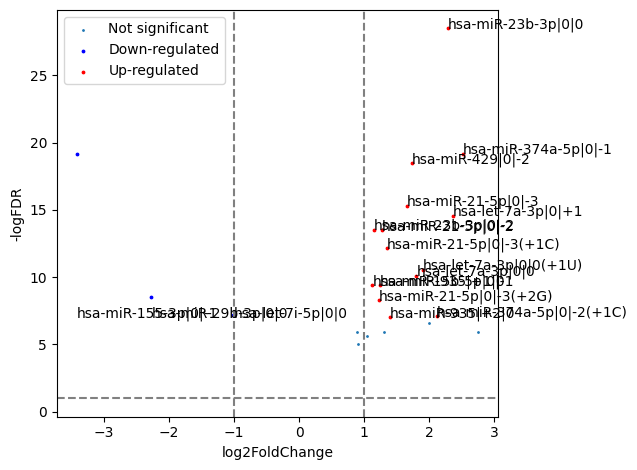

In [14]:


plt.scatter(x=res_24['log2FoldChange'],y=res_24['padj'].apply(lambda x:-np.log2(x)),s=1,label="Not significant")

# highlight down- or up- regulated genes
down = res_24[(res_24['log2FoldChange']<=-1)&(res_24['padj']<=0.01)]
up = res_24[(res_24['log2FoldChange']>=1)&(res_24['padj']<=0.01)]

plt.scatter(x=down['log2FoldChange'],y=down['padj'].apply(lambda x:-np.log2(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['log2FoldChange'],y=up['padj'].apply(lambda x:-np.log2(x)),s=3,label="Up-regulated",color="red")

for i,r in up.iterrows():
    plt.text(x=r['log2FoldChange'],y=-np.log2(r['padj']),s=i)
    
for j,k in down.iterrows():
    plt.text(x=k['log2FoldChange'],y=-np.log2(r['padj']),s=j)

plt.xlabel("log2FoldChange")
plt.ylabel("-logFDR")

plt.axvline(-1,color="grey",linestyle="--")
plt.axvline(1,color="grey",linestyle="--")
plt.axhline(1,color="grey",linestyle="--")
plt.legend()

plt.tight_layout()

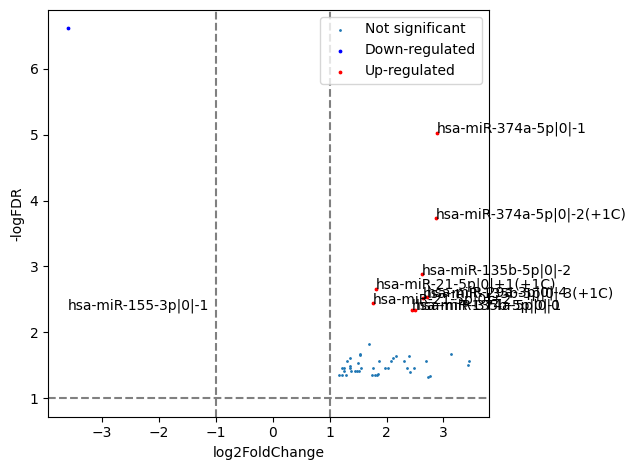

In [15]:
plt.scatter(x=res_12['log2FoldChange'],y=res_12['padj'].apply(lambda x:-np.log10(x)),s=1,label="Not significant")

# highlight down- or up- regulated genes
down = res_12[(res_12['log2FoldChange']<=-1)&(res_12['padj']<=0.01)]
up = res_12[(res_12['log2FoldChange']>=1)&(res_12['padj']<=0.01)]

plt.scatter(x=down['log2FoldChange'],y=down['padj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['log2FoldChange'],y=up['padj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

for i,r in up.iterrows():
    plt.text(x=r['log2FoldChange'],y=-np.log10(r['padj']),s=i)
    
for j,k in down.iterrows():
    plt.text(x=k['log2FoldChange'],y=-np.log10(r['padj']),s=j)

plt.xlabel("log2FoldChange")
plt.ylabel("-logFDR")

plt.axvline(-1,color="grey",linestyle="--")
plt.axvline(1,color="grey",linestyle="--")
plt.axhline(1,color="grey",linestyle="--")
plt.legend()

plt.tight_layout()

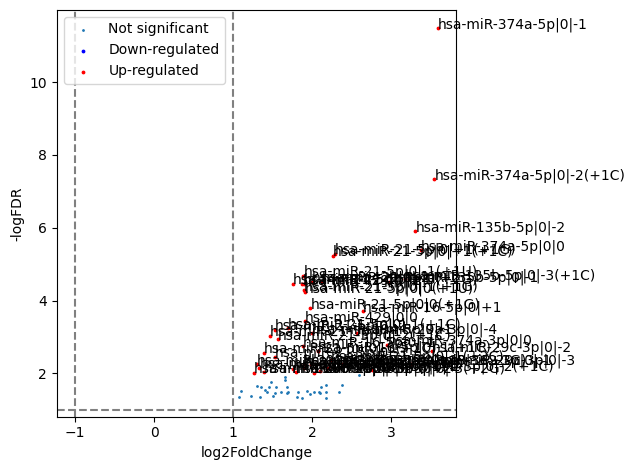

In [16]:
plt.scatter(x=res_4['log2FoldChange'],y=res_4['padj'].apply(lambda x:-np.log10(x)),s=1,label="Not significant")

# highlight down- or up- regulated genes
down = res_4[(res_4['log2FoldChange']<=-1)&(res_4['padj']<=0.01)]
up = res_4[(res_4['log2FoldChange']>=1)&(res_4['padj']<=0.01)]

plt.scatter(x=down['log2FoldChange'],y=down['padj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['log2FoldChange'],y=up['padj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

for i,r in up.iterrows():
    plt.text(x=r['log2FoldChange'],y=-np.log10(r['padj']),s=i)
    
for j,k in down.iterrows():
    plt.text(x=k['log2FoldChange'],y=-np.log10(r['padj']),s=j)

plt.xlabel("log2FoldChange")
plt.ylabel("-logFDR")

plt.axvline(-1,color="grey",linestyle="--")
plt.axvline(1,color="grey",linestyle="--")
plt.axhline(1,color="grey",linestyle="--")
plt.legend()

plt.tight_layout()

In [17]:
res_4.head(2)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
hsa-miR-374a-5p|0|-1,267.783632,3.593546,0.456806,7.866673,3.641980e-15,3.350622e-12
hsa-miR-374a-5p|0|-2(+1C),165.066056,3.550321,0.549282,6.463562,1.022668e-10,4.704272e-08


In [18]:
# returns first top N isoforms from DEGs

def get_mirnas(df, top):
    names_list = []
    for i in range(df.index.shape[0]):
        index_parts = df.index[i].split('-')[0:4]
        new_name = '-'.join(index_parts)
        if '|' in new_name:
            new_name = new_name.split('|')[0]
        names_list.append(new_name)
    return names_list[:top]

In [19]:
top_4hpi = get_mirnas(res_4, 40)
top_12hpi = get_mirnas(res_12, 40)
top_24hpi = get_mirnas(res_24, 40)

In [20]:
targets = pd.read_csv('/Users/sofialuk/Desktop/mirna_shit/miRDB_v6.0_prediction_result.txt', sep = '\t', header = None) 

In [21]:
targets = targets[targets[0].str.contains('hsa')]

In [22]:
targets = targets[targets[2] > 80]
targets

,0,1,2
1776178,hsa-let-7a-2-3p,NM_001130845,89.899500
1776181,hsa-let-7a-2-3p,NM_014423,80.149571
1776186,hsa-let-7a-2-3p,NM_001207024,84.703100
1776192,hsa-let-7a-2-3p,NM_020529,94.817070
1776195,hsa-let-7a-2-3p,NM_002970,88.843700
...,...,...,...
5151898,hsa-miR-99b-5p,NM_001297665,86.224900
5151901,hsa-miR-99b-5p,NM_021643,95.808660
5151912,hsa-miR-99b-5p,NM_001281737,87.101500
5151913,hsa-miR-99b-5p,NM_006041,89.138400


In [23]:
# Annotate gene symbols using mygene package
mg = mygene.MyGeneInfo()
geneSyms = mg.querymany(targets[1], scopes='refseq')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-35000...done.
queryin

querying 271001-272000...done.
querying 272001-273000...done.
querying 273001-274000...done.
querying 274001-275000...done.
querying 275001-276000...done.
querying 276001-277000...done.
querying 277001-278000...done.
querying 278001-279000...done.
querying 279001-280000...done.
querying 280001-281000...done.
querying 281001-282000...done.
querying 282001-283000...done.
querying 283001-284000...done.
querying 284001-285000...done.
querying 285001-286000...done.
querying 286001-287000...done.
querying 287001-288000...done.
querying 288001-289000...done.
querying 289001-290000...done.
querying 290001-291000...done.
querying 291001-292000...done.
querying 292001-293000...done.
querying 293001-294000...done.
querying 294001-295000...done.
querying 295001-296000...done.
querying 296001-297000...done.
querying 297001-298000...done.
querying 298001-299000...done.
querying 299001-300000...done.
querying 300001-301000...done.
querying 301001-302000...done.
querying 302001-303000...done.
querying

querying 535001-536000...done.
querying 536001-537000...done.
querying 537001-538000...done.
querying 538001-539000...done.
querying 539001-540000...done.
querying 540001-541000...done.
querying 541001-542000...done.
querying 542001-543000...done.
querying 543001-544000...done.
querying 544001-545000...done.
querying 545001-546000...done.
querying 546001-547000...done.
querying 547001-548000...done.
querying 548001-549000...done.
querying 549001-550000...done.
querying 550001-551000...done.
querying 551001-552000...done.
querying 552001-553000...done.
querying 553001-554000...done.
querying 554001-555000...done.
querying 555001-556000...done.
querying 556001-557000...done.
querying 557001-558000...done.
querying 558001-559000...done.
querying 559001-560000...done.
querying 560001-561000...done.
querying 561001-562000...done.
querying 562001-563000...done.
querying 563001-564000...done.
querying 564001-565000...done.
querying 565001-566000...done.
querying 566001-567000...done.
querying

querying 799001-800000...done.
querying 800001-801000...done.
querying 801001-802000...done.
querying 802001-803000...done.
querying 803001-804000...done.
querying 804001-805000...done.
querying 805001-806000...done.
querying 806001-807000...done.
querying 807001-808000...done.
querying 808001-809000...done.
querying 809001-810000...done.
querying 810001-811000...done.
querying 811001-812000...done.
querying 812001-812240...done.
Finished.
36451 input query terms found dup hits:
	[('NM_001130845', 39), ('NM_014423', 152), ('NM_001207024', 33), ('NM_020529', 11), ('NM_002970', 8)
857 input query terms found no hit:
	['NM_001305396', 'NM_001305397', 'NM_001305395', 'NM_001017973', 'NM_001305396', 'NM_001305397', 'NM
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [24]:
annot = pd.DataFrame(geneSyms)

In [25]:
annot = annot.reset_index()

In [26]:
targets = targets.reset_index()

In [27]:
annot['mirna'] = targets[0]
annot

,index,query,_id,_score,entrezgene,name,symbol,taxid,notfound,mirna
0,0,NM_001130845,604,12.170492,604,BCL6 transcription repressor,BCL6,9606.0,NaN,hsa-let-7a-2-3p
1,1,NM_014423,27125,13.115369,27125,ALF transcription elongation factor 4,AFF4,9606.0,NaN,hsa-let-7a-2-3p
2,2,NM_001207024,4074,8.101730,4074,"mannose-6-phosphate receptor, cation dependent",M6PR,9606.0,NaN,hsa-let-7a-2-3p
3,3,NM_020529,4792,33.219017,4792,NFKB inhibitor alpha,NFKBIA,9606.0,NaN,hsa-let-7a-2-3p
4,4,NM_002970,6303,30.520512,6303,spermidine/spermine N1-acetyltransferase 1,SAT1,9606.0,NaN,hsa-let-7a-2-3p
...,...,...,...,...,...,...,...,...,...,...
812235,812235,NM_001297665,22996,4.545586,22996,tetratricopeptide repeat domain 39A,TTC39A,9606.0,NaN,hsa-miR-99b-5p
812236,812236,NM_021643,28951,30.520512,28951,tribbles pseudokinase 2,TRIB2,9606.0,NaN,hsa-miR-99b-5p
812237,812237,NM_001281737,2110,24.161753,2110,electron transfer flavoprotein dehydrogenase,ETFDH,9606.0,NaN,hsa-miR-99b-5p
812238,812238,NM_006041,9953,26.069204,9953,heparan sulfate-glucosamine 3-sulfotransferase...,HS3ST3B1,9606.0,NaN,hsa-miR-99b-5p


In [28]:
mirna_targets = annot[['mirna', 'symbol']]
mirna_targets

,mirna,symbol
0,hsa-let-7a-2-3p,BCL6
1,hsa-let-7a-2-3p,AFF4
2,hsa-let-7a-2-3p,M6PR
3,hsa-let-7a-2-3p,NFKBIA
4,hsa-let-7a-2-3p,SAT1
...,...,...
812235,hsa-miR-99b-5p,TTC39A
812236,hsa-miR-99b-5p,TRIB2
812237,hsa-miR-99b-5p,ETFDH
812238,hsa-miR-99b-5p,HS3ST3B1


In [35]:
mirna_targets[mirna_targets['mirna'].str.contains('4295')]

,mirna,symbol
328566,hsa-miR-4295,ESR1
328567,hsa-miR-4295,SYBU
328568,hsa-miR-4295,MDM4
328569,hsa-miR-4295,SIX4
328570,hsa-miR-4295,LDAF1
...,...,...
329271,hsa-miR-4295,FSTL5
329272,hsa-miR-4295,MB21D2
329273,hsa-miR-4295,POP7
329274,hsa-miR-4295,SFMBT1


In [29]:
targets4  =  mirna_targets[mirna_targets['mirna'].str.contains('|'.join(top_4hpi))]
targets12  =  mirna_targets[mirna_targets['mirna'].str.contains('|'.join(top_12hpi))]
targets24  =  mirna_targets[mirna_targets['mirna'].str.contains('|'.join(top_24hpi))]

# select specific miRNA targets

In [30]:
#targets4 = targets[targets[0].str.contains('|'.join(top_4hpi))]
#targets12 = targets[targets[0].str.contains('|'.join(top_12hpi))]
#targets24 = targets[targets[0].str.contains('|'.join(top_24hpi))]

In [31]:
targets4.to_csv('targets4.csv')
targets12.to_csv('targets12.csv')
targets24.to_csv('targets24.csv')